原始特征形状: (40, 222)
降维后特征形状: (40, 24)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 256)               6400      
                                                                 
 dropout_48 (Dropout)        (None, 256)               0         
                                                                 
 dense_52 (Dense)            (None, 128)               32896     
                                                                 
 dropout_49 (Dropout)        (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dropout_50 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)

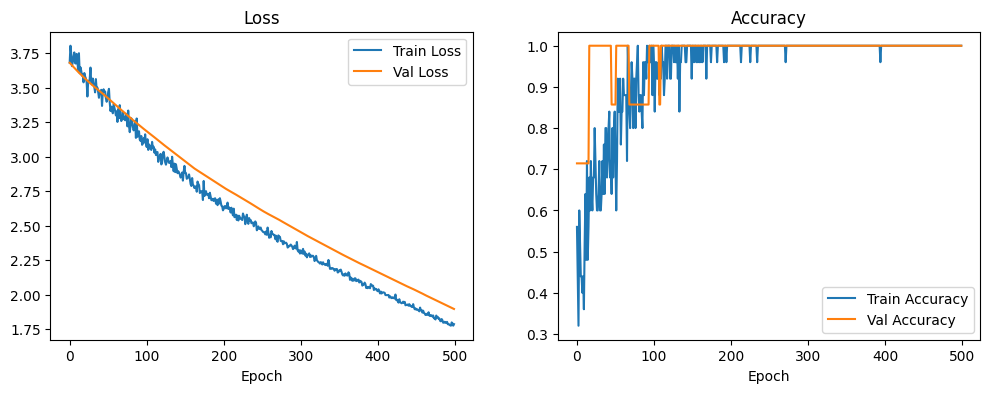

1/1 [==============================] - 0s 19ms/step - loss: 1.8053 - accuracy: 1.0000
Test Loss: 1.8053 - Test Accuracy: 1.0000
1/1 [==============================] - 0s 54ms/step
Predicted labels: [0 0 1 1 0 1 0 1]


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pandas as pd
from glob import glob
import networkx as nx
import math
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

# 数据路径设置
ASD_folder = r'/home/chester/data/connectivity_dataset/feature_extration/ASD' 
TD_folder  = r'/home/chester/data/connectivity_dataset/feature_extration/TD'

def load_connectivity_files(folder, label):
    file_paths = glob(os.path.join(folder, '*.csv'))
    data = []
    labels = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, index_col=0)
        matrix = df.values.astype(np.float32)
        data.append(matrix)
        labels.append(label)
    return data, labels

data_asd, labels_asd = load_connectivity_files(ASD_folder, 0)
data_td, labels_td   = load_connectivity_files(TD_folder, 1)
data_all = data_asd + data_td
labels_all = labels_asd + labels_td

def global_efficiency(G):
    n = len(G)
    if n < 2:
        return 0
    total = 0
    for node in G:
        lengths = nx.single_source_shortest_path_length(G, node)
        total += sum(1/d for target, d in lengths.items() if d > 0)
    return total / (n * (n - 1))

def extract_features(matrix):
    n = matrix.shape[0]
    triu_indices = np.triu_indices(n, k=1)
    triu_features = matrix[triu_indices]
    
    # 调整阈值为70%分位数
    threshold = np.percentile(matrix, 70)
    bin_matrix = (matrix > threshold).astype(int)
    G = nx.from_numpy_array(bin_matrix)
    
    if G.number_of_edges() == 0:
        avg_clustering = 0
        char_path_length = 0
        graph_global_eff = 0
        small_world = 0
        density = 0
        degree_centrality = 0
    else:
        avg_clustering = nx.average_clustering(G)
        if nx.is_connected(G):
            char_path_length = nx.average_shortest_path_length(G)
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            subG = G.subgraph(largest_cc)
            char_path_length = nx.average_shortest_path_length(subG) if subG.number_of_nodes() > 1 else 0
        graph_global_eff = global_efficiency(G)
        
        density = nx.density(G)
        degree_centrality = np.mean(list(nx.degree_centrality(G).values()))
        
        Lrand = math.log(n) / math.log(n * density) if density * n > 1 else np.inf
        Crand = density
        if char_path_length == 0 or Lrand == np.inf or Crand == 0:
            small_world = 0
        else:
            small_world = (avg_clustering / Crand) / (char_path_length / Lrand)
    
    mean_val = np.mean(matrix)
    std_val = np.std(matrix)
    max_val = np.max(matrix)
    min_val = np.min(matrix)
    skewness = skew(matrix.flatten())
    kurt = kurtosis(matrix.flatten())
    
    graph_features = np.array([avg_clustering, char_path_length, graph_global_eff, small_world, density, degree_centrality], dtype=np.float32)
    stats_features = np.array([mean_val, std_val, max_val, min_val, skewness, kurt], dtype=np.float32)
    
    return np.concatenate([triu_features, graph_features, stats_features])

# 特征提取
features_all = [extract_features(mat) for mat in data_all]
X = np.array(features_all)
y = np.array(labels_all)
print("原始特征形状:", X.shape)

# 数据预处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 特征降维（保留95%方差）
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print("降维后特征形状:", X_pca.shape)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# 计算类别权重
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = {0: class_weights[0], 1: class_weights[1]}

# 构建优化后的模型
input_dim = X_train.shape[1]
model = Sequential([
    Dense(256, activation='relu', input_dim=input_dim, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# 设置回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

# 训练模型
history = model.fit(X_train, y_train,
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weights,
                    callbacks=callbacks)

# 可视化训练过程
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 测试集评估
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")

# 预测与结果展示
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)
print("Predicted labels:", predicted_labels)
